# Creating a Function to Collect Stock and Trends Data for Any Ticker

The goal of this workbook is to use APIs to get the following for any ticker:
- Daily open, high, low, close, adjusted close, volume, dividend amount, and split coefficient
- Google trends score

Over the period 01.02.18-06.1.21

Step One: Create a DataFrame for an example ticker. In this case I will use IBM.

Step Two: Generalize the code used for IBM into a function that can be used for any ticker. That function will be named create_ticker_df

## Step One: Create a DataFrame for an example ticker. In this case I will use IBM.

### Collecting Stock Data Using Alpha Vantage

In [443]:
key = '49KFJCFS3P6CEU4F'

In [444]:
from alpha_vantage.timeseries import TimeSeries

In [445]:
#time series daily adjusted. Works but only goes back to 9/19
import requests

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=IBM&apikey=49KFJCFS3P6CEU4F&outputsize=full'
r = requests.get(url)
data = r.json()

print(data['Time Series (Daily)']['2021-06-01'])
print(data['Time Series (Daily)']['2018-01-02'])

{'1. open': '145.0', '2. high': '145.83', '3. low': '143.75', '4. close': '144.19', '5. adjusted close': '144.19', '6. volume': '2417455', '7. dividend amount': '0.0000', '8. split coefficient': '1.0'}
{'1. open': '154.5', '2. high': '154.81', '3. low': '153.54', '4. close': '154.25', '5. adjusted close': '130.577642951', '6. volume': '4195225', '7. dividend amount': '0.0000', '8. split coefficient': '1.0'}


The alpha vantage api is able to get the data for the time frame we want. The next step is to translate the JSON into a DataFrame and filter for the date range that I want.

In [446]:
import pandas as pd

In [447]:
ibm = pd.DataFrame(data['Time Series (Daily)']).T

In [448]:
ibm['date'] = ibm.index

In [449]:
ibm.index = pd.to_datetime(ibm['date'])

In [450]:
ibm = ibm[ibm['date'] > '2018-01-01']
ibm = ibm[ibm['date'] < '2021-06-02']
ibm.drop(columns = 'date', inplace = True)

In [451]:
ibm.sort_index(inplace=True)

In [452]:
ibm.shape

(859, 8)

Now our dataframe is the correct date range. Now it is time to fix the data types and add a column for the daily lag and percent change

In [453]:
ibm['daily_lag'] =  ibm['5. adjusted close'].shift(1)
ibm.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,daily_lag
date,,,,,,,,,
2018-01-02,154.5,154.81,153.54,154.25,130.577642951,4195225,0.0000,1.0,NaN
2018-01-03,157.34,159.81,156.33,158.49,134.166940883,9439063,0.0000,1.0,130.577642951
2018-01-04,159.65,162.32,159.37,161.7,136.884310309,7363843,0.0000,1.0,134.166940883
2018-01-05,162.44,162.9,161.1,162.49,137.553071008,5162075,0.0000,1.0,136.884310309
2018-01-08,162.66,163.91,161.7,163.47,138.382672889,5101023,0.0000,1.0,137.553071008


In [454]:
for col in ibm.columns:
    ibm[col] = pd.to_numeric(ibm[col])

In [455]:
ibm['daily_returns'] = ibm['5. adjusted close'] - ibm['daily_lag']
ibm['daily_pct_return'] = ibm['daily_returns']/ibm['5. adjusted close'].shift(1)
ibm['rolling_3d_adj_close'] = ibm['5. adjusted close'].rolling(3).mean()

ibm.drop(columns = 'daily_lag', inplace = True)

To help account for the effect of covid on the stock market as a whole, we will add a column to our dataset that is the adjusted close of the SPDR S&P 500 ETF. It is the largest ETF in the world and tracks the S&P 500, making it a good proxy for the performance of the market overall

In [456]:
def spdr_adj_close():
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=spy&apikey=49KFJCFS3P6CEU4F&outputsize=full'
    r = requests.get(url)
    data = r.json()
    df = pd.DataFrame(data['Time Series (Daily)']).T
    df['date'] = df.index
    df.index = pd.to_datetime(df['date'])
    df = df[df['date'] > '2018-01-01']
    df = df[df['date'] < '2021-06-02']
    df.drop(columns = 'date', inplace = True)
    df.sort_index(inplace=True)
    return df['5. adjusted close']

In [457]:
ibm.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,daily_returns,daily_pct_return,rolling_3d_adj_close
date,,,,,,,,,,,
2018-01-02,154.50,154.81,153.54,154.25,130.577643,4195225,0.0,1.0,NaN,NaN,NaN
2018-01-03,157.34,159.81,156.33,158.49,134.166941,9439063,0.0,1.0,3.589298,0.027488,NaN
2018-01-04,159.65,162.32,159.37,161.70,136.884310,7363843,0.0,1.0,2.717369,0.020254,133.876298
2018-01-05,162.44,162.90,161.10,162.49,137.553071,5162075,0.0,1.0,0.668761,0.004886,136.201441
2018-01-08,162.66,163.91,161.70,163.47,138.382673,5101023,0.0,1.0,0.829602,0.006031,137.606685


In [458]:
ibm.index.dtype

dtype('<M8[ns]')

In [459]:
pton.dtypes

open               float64
high               float64
low                float64
close              float64
adjusted_close     float64
volume               int64
dividend amount    float64
split_coef         float64
trend_score          int32
dtype: object

## Collecting Trends Data Using Google Trends API

In [460]:
import pandas as pd                        
from pytrends.request import TrendReq
pytrend = TrendReq()

In [461]:
pytrend.build_payload(kw_list=['IBM'])
# Interest by Region
df = pytrend.interest_over_time()
df.tail(10)

,IBM,isPartial
date,,
2021-05-02,52,False
2021-05-09,53,False
2021-05-16,52,False
2021-05-23,52,False
2021-05-30,49,False
2021-06-06,51,False
2021-06-13,49,False
2021-06-20,48,False
2021-06-27,48,False


In [462]:
#google trends only reports data by the week. Since the dataframe we want has a daily index, we will fill out the days based on the trend score at the beginning of that week.
trends = df['IBM'].resample('D', convention = 'start').pad()

In [463]:
trends = pd.DataFrame(trends)
trends.rename(columns = {'IBM':'trend_score'}, inplace = True)
trends

,trend_score
date,
2016-07-17,81
2016-07-18,81
2016-07-19,81
2016-07-20,81
2016-07-21,81
...,...
2021-06-30,48
2021-07-01,48
2021-07-02,48


Now we have the trends data on a daily index. The next step is to merge the stock data with the trends data. We will do a left merge such that we keep only the days where we have stock data (ie trading days after IPO)

In [464]:
ibm = ibm.merge(trends, how = 'left', left_index = True, right_index = True)

## Create a function to collect the data and create a dataframe for any ticker

The below function is the same code I used for IBM but generalized so the function can be used for any ticker

In [465]:
#create function from the code above that can be used for any ticker
def create_ticker_df (ticker):
    '''Returns a DataFrame of stock and Google Trends data for the given ticker. The output will be daily data 1/2/18-6/1/21'''
    #collect stock data using Alpha Vantage API
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={ticker}&apikey=49KFJCFS3P6CEU4F&outputsize=full'
    r = requests.get(url)
    data = r.json()
    df = pd.DataFrame(data['Time Series (Daily)']).T
    
    #filter to include 2018.01.02 - 2021.06.01
    df['date'] = df.index
    df.index = pd.to_datetime(df['date'])
    df = df[df['date'] > '2018-01-01']
    df = df[df['date'] < '2021-06-02']
    df.drop(columns = 'date', inplace = True)
    df.sort_index(inplace=True)
    
    #add lag columns
    days_to_lag = [1,2,3,7,30,90,365]
    for day in days_to_lag:
        df[f'lag_{day}'] = df['5. adjusted close'].shift(day)
    
    #fix dtypes and column names
    df['spdr_adj_close'] = spdr_adj_close()
   
    
    for col in df.columns:
        df[col] = pd.to_numeric(df[col])
    df['daily_returns'] = df['5. adjusted close'] - df['lag_1']
    df['daily_pct_return'] = df['daily_returns']/df['5. adjusted close'].shift(1)
    df['rolling_3d_adj_close'] = df['5. adjusted close'].rolling(3).mean()
    df.rename(columns = {'1. open': 'open',
                        '2. high': 'high',
                        '3. low': 'low',
                        '4. close': 'close',
                        '5. adjusted close': 'adjusted_close',
                        '6. volume': 'volume',
                        '7. dividend amount': 'dividend amount',
                        '8. split coefficient': 'splitcoef',
                        'daily_returns' : 'daily_returns'}, inplace = True)
        
    #Collect Google Trends data using pytrends api
    pytrend.build_payload(kw_list=[ticker])
    google = pytrend.interest_over_time()
    trends = google[ticker].resample('D', convention = 'start').pad()
    trends = pd.DataFrame(trends)
    trends.rename(columns = {ticker:'trend_score'}, inplace = True)
    
    #merge stock data with trends data
    df = df.merge(trends, how = 'left', left_index = True, right_index = True)
    
    return df

Test create_ticker_df on Apple:

In [466]:
aapl = create_ticker_df('aapl')

In [467]:
aapl

,open,high,low,close,adjusted_close,volume,dividend amount,splitcoef,lag_1,lag_2,lag_3,lag_7,lag_30,lag_90,lag_365,spdr_adj_close,daily_returns,daily_pct_return,rolling_3d_adj_close,trend_score
date,,,,,,,,,,,,,,,,,,,,
2018-01-02,170.160,172.30,169.26,172.26,41.308268,25048048,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.328547,NaN,NaN,NaN,19
2018-01-03,172.530,174.55,171.96,172.23,41.301074,28819653,0.0,1.0,41.308268,NaN,NaN,NaN,NaN,NaN,NaN,253.924553,-0.007194,-0.000174,NaN,19
2018-01-04,172.540,173.47,172.08,173.03,41.492916,22211345,0.0,1.0,41.301074,41.308268,NaN,NaN,NaN,NaN,NaN,254.994815,0.191841,0.004645,41.367419,19
2018-01-05,173.440,175.37,173.05,175.00,41.965325,23016177,0.0,1.0,41.492916,41.301074,41.308268,NaN,NaN,NaN,NaN,256.694092,0.472410,0.011385,41.586438,19
2018-01-08,174.350,175.61,173.93,174.35,41.809454,20134092,0.0,1.0,41.965325,41.492916,41.301074,NaN,NaN,NaN,NaN,257.163506,-0.155871,-0.003714,41.755898,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-25,127.820,128.32,126.32,126.90,126.900000,72009482,0.0,1.0,127.100000,125.430000,127.310000,127.45,134.203253,128.499945,66.898511,416.857700,-0.200000,-0.001574,126.476667,22
2021-05-26,126.955,127.39,126.42,126.85,126.850000,56575920,0.0,1.0,126.900000,127.100000,125.430000,126.27,131.807301,126.735576,67.068988,417.684956,-0.050000,-0.000394,126.950000,22
2021-05-27,126.440,127.64,125.08,125.28,125.280000,94625601,0.0,1.0,126.850000,126.900000,127.100000,124.85,134.273135,127.423381,67.980667,417.904229,-1.570000,-0.012377,126.343333,22


In [468]:
aapl.dtypes

open                    float64
high                    float64
low                     float64
close                   float64
adjusted_close          float64
volume                    int64
dividend amount         float64
splitcoef               float64
lag_1                   float64
lag_2                   float64
lag_3                   float64
lag_7                   float64
lag_30                  float64
lag_90                  float64
lag_365                 float64
spdr_adj_close          float64
daily_returns           float64
daily_pct_return        float64
rolling_3d_adj_close    float64
trend_score               int32
dtype: object

### EDA: Is the data we collected for AAPL actually correct?

In [469]:
from IPython.display import Image
import matplotlib.pyplot as plt

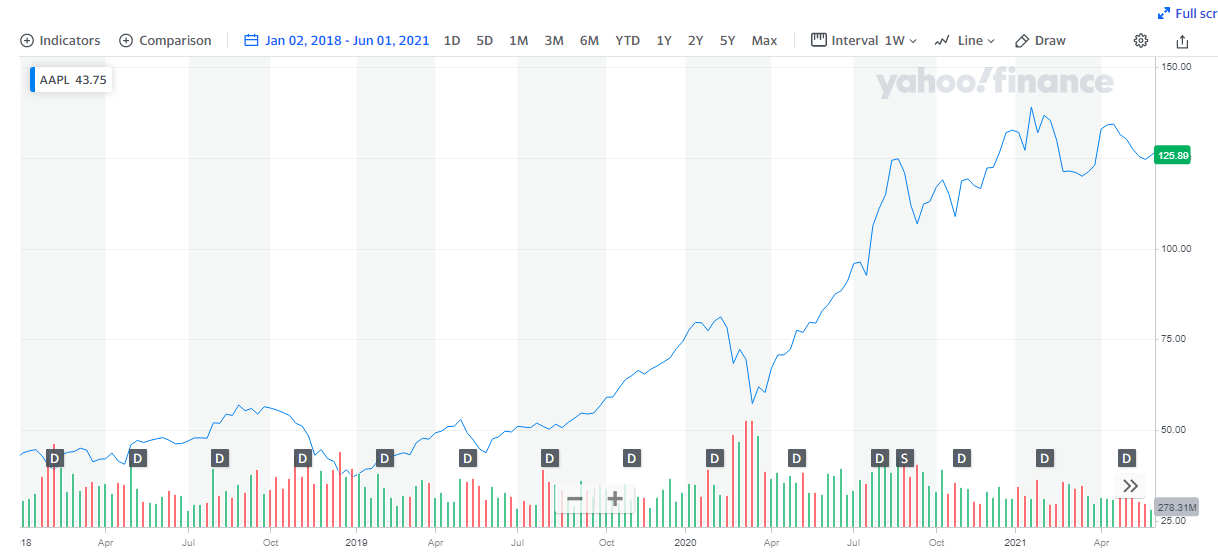

In [470]:
Image('./Pictures/AAPL Snip.png', width=700)

Above is the stock price chart for AAPL 1.2.18-6.1.21 per Yahoo Finance. Below is the chart of our closing prices for that same time period.

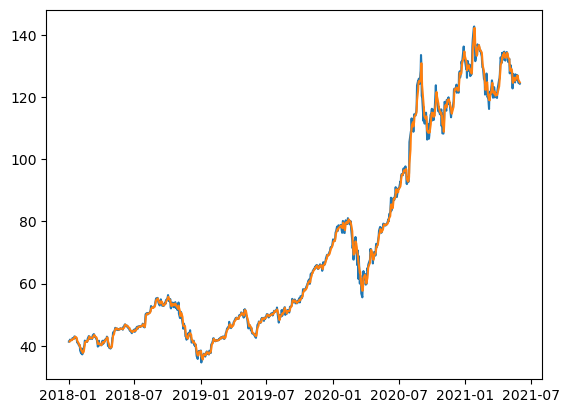

In [471]:
plt.plot(aapl['adjusted_close'])
plt.plot(aapl['rolling_3d_adj_close'])

Are these two graphs the same?

<AxesSubplot:>

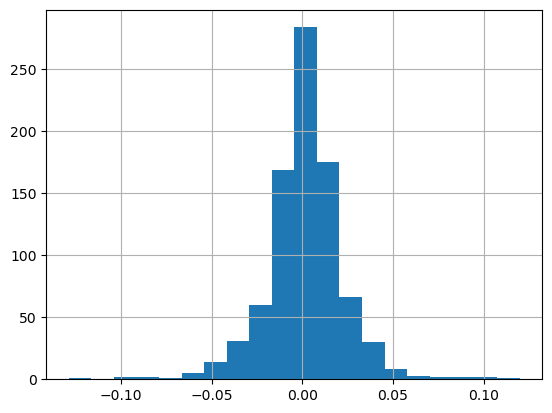

In [472]:
aapl['daily_pct_return'].hist(bins = 20)

The histogram of daily returns is normally shaped with a few outliers. This fits our expectations about the behavior of Apple's stock price

In [473]:
mean_return = aapl['daily_pct_return'].mean()
mean_return

0.0015205344430411372

A mean return close to zero is fitting with our expectations

In [474]:
std_return = aapl['daily_pct_return'].std()
std_return

0.021715717046206954

A low standard deviation is fitting with our expecations because it means that most days there will not be a large swing in the stock price

In [475]:
aapl['daily_pct_return'].kurtosis()

5.391441242809365

A high kurtosis value means that the tail of the distribution is a small amount of the dataset. This fits our expectations because it is another indicator that days with large price swings are rare

### Checking for seasonality, autocorrelation

In [476]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [477]:
plt.style.use('default')

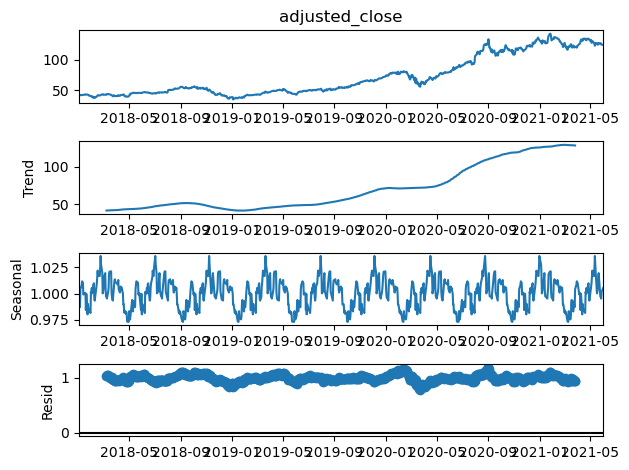

In [478]:
# Decompose time series into trend, seasonal, and residual components.
decomp = seasonal_decompose(aapl['adjusted_close'], period = 90, model = 'multiplicative')

# Plot the decomposed time series.
decomp.plot();

###

We already have lag data set up for 1,2,3,7,30,90, and 365 days. We can use statsmodels acf plot to view the pacf plot for the lags 30 and below. For the correlation of the quarterly lag and the yearly lag we can view those individually below.

In [479]:
from statsmodels.graphics.tsaplots import plot_pacf

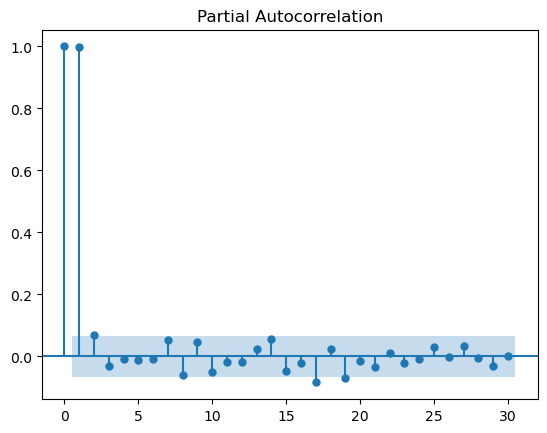

In [480]:
plot_pacf(aapl['adjusted_close'], lags = 30);

The PACF plot above shows that lag_1 has by far the highest partial autocorrelation with adjusted_close. All of the other lags under 30 days fall into or very close to the blue shaded area, meaning that they are likely not statistically signifigant.